# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1310s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 
from pathlib import Path

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.jpg')
x_data = []
y_data = []

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = int(target)
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    x_data.append(test_image)
    y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1525, 32, 20, 3)
(1525, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.2
Rotation_Angle = 5
ZoomRange = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
382/382 [==============================] - 3s 6ms/step - loss: 2.1124 - accuracy: 0.3177
Epoch 2/500
382/382 [==============================] - 2s 6ms/step - loss: 1.1079 - accuracy: 0.6552
Epoch 3/500
382/382 [==============================] - 3s 7ms/step - loss: 0.7610 - accuracy: 0.7657
Epoch 4/500
382/382 [==============================] - 3s 7ms/step - loss: 0.5986 - accuracy: 0.8209
Epoch 5/500
382/382 [==============================] - 3s 7ms/step - loss: 0.5159 - accuracy: 0.8464: 0s - loss: 0.5176 - accu
Epoch 6/500
382/382 [==============================] - 3s 7ms/step - loss: 0.4714 - accuracy: 0.8648
Epoch 7/500
382/382 [==============================] - 3s 7ms/step - loss: 0.3256 - accuracy: 0.9120
Epoch 8/500
382/382 [==============================] - 2s 6ms/step - loss: 0.2949 - accuracy: 0.9010
Epoch 9/500
382/382 [==============================] - 3s 7ms/step - loss: 0.2932 - accuracy: 0.9098
Epoch 10/500
382/382 [==============================] - 3s 7ms/st

382/382 [==============================] - 4s 10ms/step - loss: 0.0286 - accuracy: 0.9894
Epoch 80/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0485 - accuracy: 0.9879
Epoch 81/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0436 - accuracy: 0.9855
Epoch 82/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0589 - accuracy: 0.9851
Epoch 83/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0229 - accuracy: 0.9943
Epoch 84/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0379 - accuracy: 0.9930
Epoch 85/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0379 - accuracy: 0.9876
Epoch 86/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0539 - accuracy: 0.9875
Epoch 87/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0171 - accuracy: 0.9946
Epoch 88/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0448 - 

382/382 [==============================] - 4s 10ms/step - loss: 0.0438 - accuracy: 0.9893
Epoch 157/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0074 - accuracy: 0.9975
Epoch 158/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0061 - accuracy: 0.9988
Epoch 159/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0229 - accuracy: 0.9930 3s - l
Epoch 160/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0250 - accuracy: 0.9964
Epoch 161/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0172 - accuracy: 0.9963
Epoch 162/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0090 - accuracy: 0.9961
Epoch 163/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0034 - accuracy: 0.9991
Epoch 164/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0193 - accuracy: 0.9954
Epoch 165/500
382/382 [==============================] - 4s 10ms/step -

382/382 [==============================] - 4s 10ms/step - loss: 0.0084 - accuracy: 0.9949
Epoch 239/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0092 - accuracy: 0.9976  - ETA: 0s - loss: 0.0
Epoch 240/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0060 - accuracy: 0.9976
Epoch 241/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0287 - accuracy: 0.9944
Epoch 242/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0129 - accuracy: 0.9935
Epoch 243/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0118 - accuracy: 0.9962
Epoch 244/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0153 - accuracy: 0.9965
Epoch 245/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0404 - accuracy: 0.9942
Epoch 246/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0048 - accuracy: 0.9985
Epoch 247/500
382/382 [==============================] 

382/382 [==============================] - 4s 10ms/step - loss: 0.0092 - accuracy: 0.9967
Epoch 386/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0042 - accuracy: 0.9966
Epoch 387/500
382/382 [==============================] - 4s 10ms/step - loss: 7.8456e-04 - accuracy: 1.0000
Epoch 388/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0294 - accuracy: 0.9977
Epoch 389/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0187 - accuracy: 0.9966
Epoch 390/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0048 - accuracy: 0.9977
Epoch 391/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0245 - accuracy: 0.9949
Epoch 392/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0202 - accuracy: 0.9978
Epoch 393/500
382/382 [==============================] - 4s 10ms/step - loss: 0.0108 - accuracy: 0.9957
Epoch 394/500
382/382 [==============================] - 4s 10ms/step - lo

382/382 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9982
Epoch 475/500
382/382 [==============================] - 3s 7ms/step - loss: 0.0131 - accuracy: 0.9980
Epoch 476/500
382/382 [==============================] - 3s 7ms/step - loss: 5.1501e-05 - accuracy: 1.0000
Epoch 477/500
382/382 [==============================] - 3s 7ms/step - loss: 2.6568e-04 - accuracy: 1.0000: 0s - loss: 2.3288e-04 - ac
Epoch 478/500
382/382 [==============================] - 3s 7ms/step - loss: 8.8347e-04 - accuracy: 0.9990
Epoch 479/500
382/382 [==============================] - 3s 7ms/step - loss: 0.0179 - accuracy: 0.9956
Epoch 480/500
382/382 [==============================] - 3s 7ms/step - loss: 0.0030 - accuracy: 0.9980
Epoch 481/500
382/382 [==============================] - 3s 7ms/step - loss: 0.0063 - accuracy: 0.9990
Epoch 482/500
382/382 [==============================] - 3s 7ms/step - loss: 0.0016 - accuracy: 0.9992
Epoch 483/500
382/382 [========================

### Learing result
 
* Visualization of the training and validation results

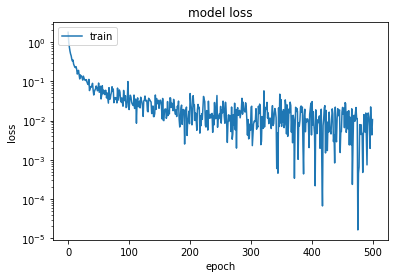

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


ziffer_sortiert_resize\2_10_dig6_20210726-190157.jpg 2 -1


ziffer_sortiert_resize\5_3_dig6_20210723-134707.jpg 5 9


ziffer_sortiert_resize\6_10_ht6_20210628-141923.jpg 6 -1


ziffer_sortiert_resize\6_D8_2020-08-19_20-22-27.jpg 6 9


ziffer_sortiert_resize\8_3_dig4_20210725-094630.jpg 8 9


ziffer_sortiert_resize\8_3_dig6_20210716-214753.jpg 8 9


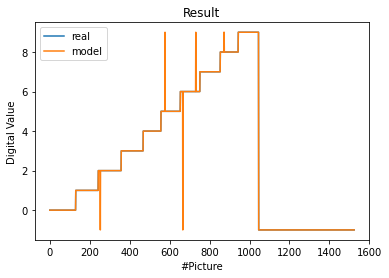

In [6]:
Input_dir='ziffer_sortiert_resize'
res = []
only_deviation = True
show_wrong_image = True

files = glob.glob(Input_dir + '/*.jpg')

for aktfile in files:
    base = os.path.basename(aktfile)
    target = base[0:1]
    if target == "N":
        zw1 = -1
    else:
        zw1 = int(target)
    expected_class = zw1
    image_in = Image.open(aktfile)
    test_image = np.array(image_in, dtype="float32")
    img = np.reshape(test_image,[1,32,20,3])
    classes = np.argmax(model.predict(img), axis=-1)
    classes = classes[0]
    if classes == 10: 
        classes = -1
    zw2 = classes
    zw3 = zw2 - zw1
    res.append(np.array([zw1, zw2, zw3]))
    if only_deviation == True:
        if str(classes) != str(expected_class):
            print(aktfile + " " + str(expected_class) +  " " + str(classes))
            if show_wrong_image == True:
                display(image_in)
    else:
        print(aktfile + " " + aktsubdir +  " " + str(classes))
        

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp_7jnxxxu\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q.tflite"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp1x8qd__b\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp1x8qd__b\assets


dig1310s1q.tflite


203200

Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.